In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [4]:
#INPUT_DIRECTORY='/content/drive/MyDrive/training'

In [5]:
#!unzip '/content/drive/MyDrive/training.zip'

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/PlantVillage",
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 2162 files belonging to 5 classes.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class_names=dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'api',
 'models']

In [10]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0])
    print(labels_batch.numpy())

tf.Tensor(
[[[170. 159. 163.]
  [165. 154. 158.]
  [165. 154. 158.]
  ...
  [152. 140. 144.]
  [149. 137. 141.]
  [154. 142. 146.]]

 [[176. 165. 169.]
  [171. 160. 164.]
  [171. 160. 164.]
  ...
  [136. 124. 128.]
  [147. 135. 139.]
  [171. 159. 163.]]

 [[169. 158. 162.]
  [164. 153. 157.]
  [163. 152. 156.]
  ...
  [120. 108. 112.]
  [159. 147. 151.]
  [144. 132. 136.]]

 ...

 [[174. 163. 167.]
  [172. 161. 165.]
  [174. 163. 167.]
  ...
  [157. 146. 144.]
  [150. 139. 137.]
  [131. 120. 118.]]

 [[173. 162. 166.]
  [169. 158. 162.]
  [170. 159. 163.]
  ...
  [130. 119. 117.]
  [134. 123. 121.]
  [139. 128. 126.]]

 [[171. 160. 164.]
  [167. 156. 160.]
  [168. 157. 161.]
  ...
  [129. 118. 116.]
  [132. 121. 119.]
  [139. 128. 126.]]], shape=(256, 256, 3), dtype=float32)
[1 0 2 0 0 1 1 0 1 0 0 0 1 0 0 1 2 0 1 0 2 1 1 1 0 0 0 0 1 1 1 0]


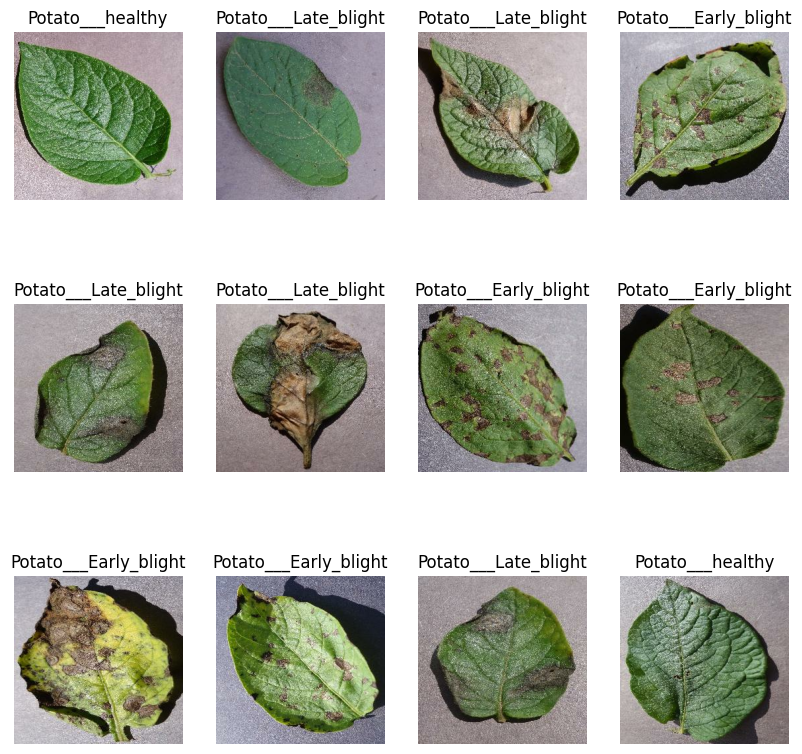

In [11]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [13]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds=dataset.take(54)
len(train_ds)

54

In [15]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+val_split+test_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),

])

In [26]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),


])

In [29]:
model.build(input_shape=input_shape)


In [30]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [33]:
history=model.fit(train_ds,
                  batch_size=BATCH_SIZE,
                  validation_data=val_ds,
                  verbose=1,
                  epochs=50,)

Epoch 1/50
54/54 [==============================] - 288s 5s/step - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.6512 - val_accuracy: 0.8490
Epoch 2/50
54/54 [==============================] - 295s 5s/step - loss: 0.0389 - accuracy: 0.9838 - val_loss: 0.2963 - val_accuracy: 0.9323
Epoch 3/50
54/54 [==============================] - 288s 5s/step - loss: 0.0498 - accuracy: 0.9821 - val_loss: 0.7141 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 293s 5s/step - loss: 0.0503 - accuracy: 0.9815 - val_loss: 1.0722 - val_accuracy: 0.7812
Epoch 5/50
54/54 [==============================] - 286s 5s/step - loss: 0.0530 - accuracy: 0.9821 - val_loss: 0.3986 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 286s 5s/step - loss: 0.0378 - accuracy: 0.9838 - val_loss: 0.3009 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 292s 5s/step - loss: 0.0272 - accuracy: 0.9936 - val_loss: 1.3010 - val_accuracy: 0.7760
Epoch 8/50
54

In [34]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 18s 2s/step - loss: 0.0243 - accuracy: 0.9922


In [35]:
print(scores)

[0.024279402568936348, 0.9921875]


In [36]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

first image to predict
actual label Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


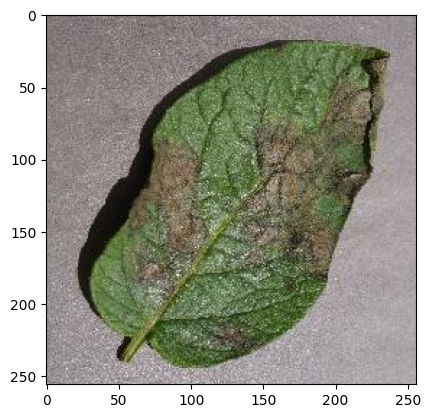

In [37]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])




In [38]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 127ms/step


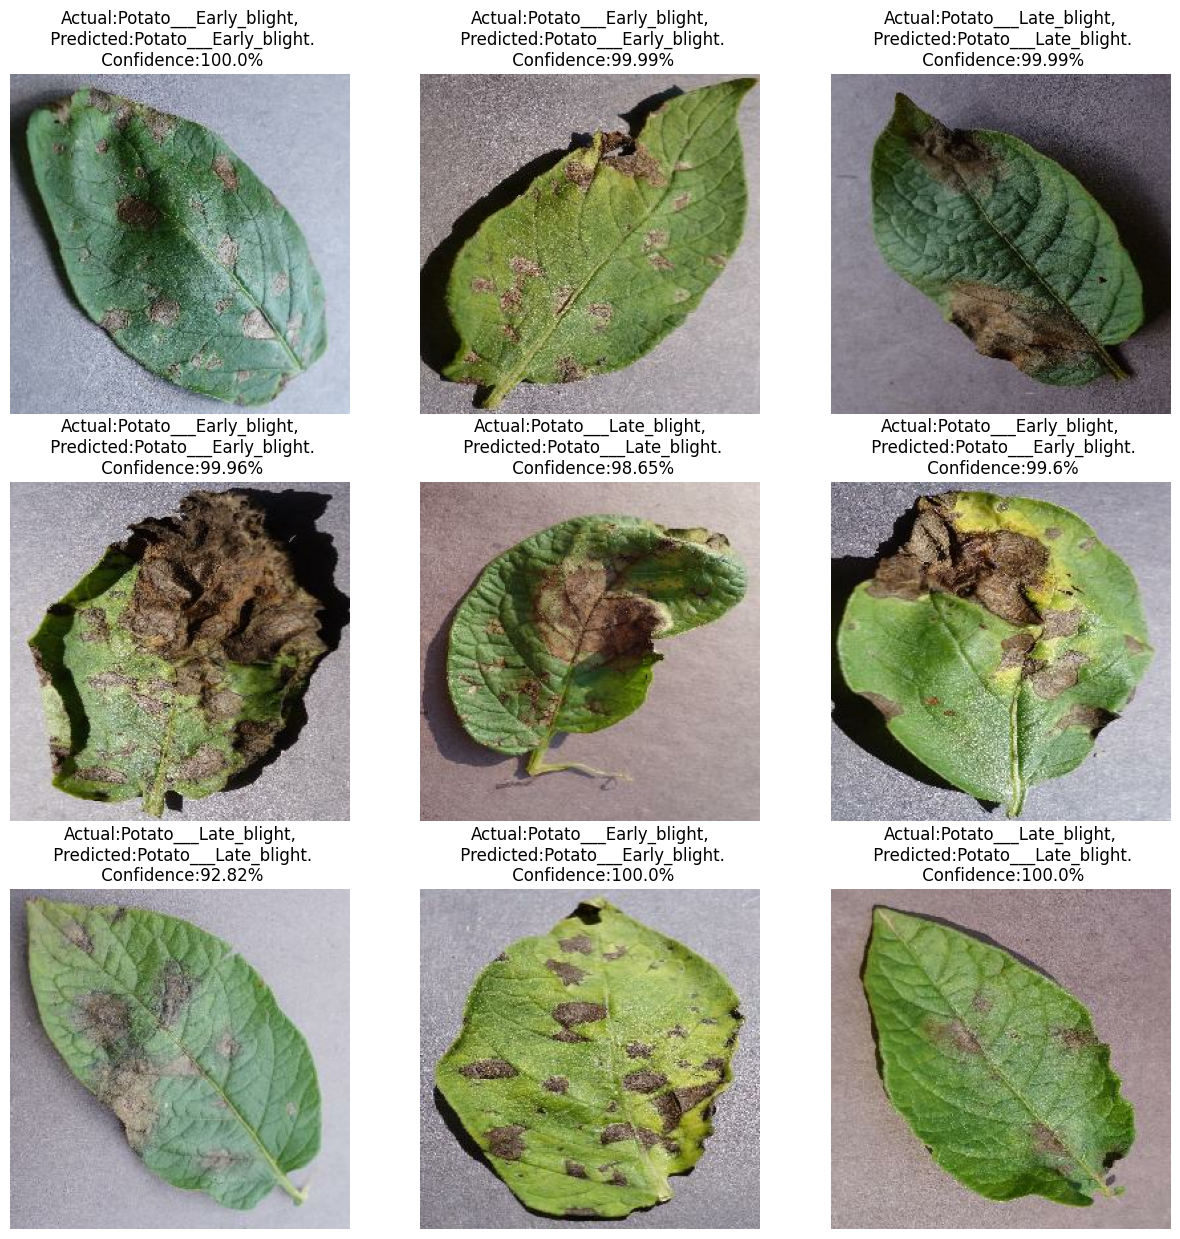

In [39]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/PlantVillage/models")+[0]])+1
model.save(f"../models/{model_version}")

In [44]:
model.save("../potatoes.hdf5")

In [45]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [46]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/PlantVillage/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (180,180)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



Writing app.py


In [47]:
!pip install pyngrok


In [48]:
!ngrok authtoken #Insert Authentication Token here, obtained from Ngrok


NAME:
  authtoken - 

USAGE:
  ngrok authtoken TOKEN [flags]

DESCRIPTION: 

OPTIONS:
      --config string       save in this config file (default /root/.config/ngrok/ngrok.yml)
  -h, --help                help for authtoken
      --log string          path to log file, 'stdout', 'stderr' or 'false' (default "false")
      --log-format string   log record format: 'term', 'logfmt', 'json' (default "term")
      --log-level string    logging level: 'debug', 'info', 'warn', 'error', 'crit' (default "info")

ERROR:  accepts 1 arg(s), received 0


In [49]:
!nohup streamlit run app.py &


nohup: appending output to 'nohup.out'


In [53]:
!pip install pyngrok --upgrade


In [59]:
import subprocess
import time

# Set the port number for your local server
port = 8000

# Start ngrok process to create a tunnel
ngrok_process = subprocess.Popen(['ngrok', 'http', str(port)])



In [61]:
ngrok_process


<Popen: returncode: None args: ['ngrok', 'http', '8000']>

In [67]:
!pip install --upgrade pyngrok


In [70]:
!ngrok http 8000


Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 567, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 555, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/process.py", line 275, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.10/subprocess.py", line 347, in call
    return p.wait(timeout=timeout)
  File "/usr/lib/python3.10/subprocess.py", line 1209, in wait
    return self._wait(timeout=timeout)
  File "/usr/lib/python3.10/subprocess.py", line 1959, in _wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.10/subprocess.py", line 1917, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt
^C


In [6]:
from pyngrok import ngrok

# Set the port that your local server is running on
port = 8000

# Open an HTTP tunnel to the local port
public_url = ngrok.connect(port, proto="http")

print("Tunnel URL:", public_url)

# Keep the program running
input("Press Enter to exit...")


Tunnel URL: NgrokTunnel: "https://cf4a-34-171-174-9.ngrok.io" -> "http://localhost:8000"


Press Enter to exit...


''

In [5]:
# Example for Flask application
if __name__ == "__main__":
    app.run(host='0.0.0.0', port=8000)


NameError: ignored

In [76]:
# Example for a simple HTTP server
from http.server import HTTPServer, SimpleHTTPRequestHandler

# Create a simple HTTP server and bind it to all network interfaces
httpd = HTTPServer(('0.0.0.0', 8000), SimpleHTTPRequestHandler)
httpd.serve_forever()


OSError: ignored

In [78]:
!lsof -i :8000


COMMAND  PID USER   FD   TYPE  DEVICE SIZE/OFF NODE NAME
python3 4047 root   55u  IPv4 2069501      0t0  TCP *:8000 (LISTEN)


In [80]:
!netstat -ano | find "8000"


/bin/bash: line 1: netstat: command not found
find: ‘8000’: No such file or directory


In [1]:
!fuser -k 8000/tcp


In [2]:
!ss -lptn 'sport = :8000'


State Recv-Q Send-Q Local Address:Port Peer Address:PortProcess


In [3]:
!ss -lptn 'sport = :8000'


State Recv-Q Send-Q Local Address:Port Peer Address:PortProcess


In [4]:
!ps aux | grep 8000


root       99742  0.0  0.0   7372  3464 ?        S    14:50   0:00 /bin/bash -c ps aux | grep 8000
root       99744  0.0  0.0   6480  2384 ?        S    14:50   0:00 grep 8000


In [7]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip


--2023-12-17 14:52:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  37.7MB/s    in 0.4s    

2023-12-17 14:52:16 (37.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [8]:
!unzip ngrok-stable-linux-amd64.zip


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [9]:
get_ipython().system_raw('./ngrok http 8501 &')


In [10]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'


Execute the next cell and the go to the following URL: https://cf4a-34-171-174-9.ngrok.io


In [ ]:
!streamlit run /content/app.py





  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.171.174.9:8501

